In [ ]:
# this cell is only for colab to download the dataset
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c facial-keypoints-detection

  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 56.8MB/s]
 82% 49.0M/60.1M [00:01<00:00, 39.9MB/s]
100% 60.1M/60.1M [00:01<00:00, 56.5MB/s]
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 68.2MB/s]
 31% 5.00M/16.0M [00:00<00:00, 40.3MB/s]
100% 16.0M/16.0M [00:00<00:00, 78.3MB/s]


In [ ]:
# This code is only for colab to unzip the dataset in colab content directory
!unzip training.zip -d train
!unzip test.zip -d test

Archive:  training.zip
  inflating: train/training.csv      
Archive:  test.zip
  inflating: test/test.csv           


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from tqdm import tqdm

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, ZeroPadding2D

In [ ]:
train = pd.read_csv("train/training.csv")
test = pd.read_csv("test/test.csv")
lookup = pd.read_csv("IdLookupTable.csv")
sample = pd.read_csv("SampleSubmission.csv")

In [ ]:
train.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [ ]:
train.fillna(method='ffill', inplace=True)

In [ ]:
imag = []
for i in range(0, 7049):
    img = train["Image"][i].split(' ')
    img = ['0' if x == '' else x for x in img]
    imag.append(img)

In [ ]:
image_list = np.array(imag, dtype="float")
X_train = image_list.reshape(-1, 96, 96, 1)

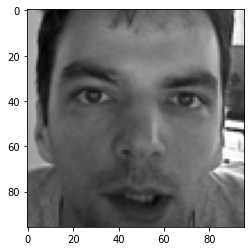

In [ ]:
plt.imshow(X_train[5].reshape(96,96),cmap='gray')
plt.show()

In [ ]:
training = train.drop('Image',axis = 1)

y_train = []
for i in range(0,7049):
    y = training.iloc[i,:]

    y_train.append(y)
y_train = np.array(y_train,dtype = 'float')

In [ ]:
y_train = pd.DataFrame(y_train)
y_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [ ]:
model = Sequential()

# layer set 1
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
# result 1 image is converted into 48 X 48 X 32 = 73K 

# layer set 2
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
# outputs 24 X 24 X 64 = 36K

# layer set 3
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
# outputs 12 X 12 X 96 = 14K

#layer set 4
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
# outputs 6 X 6 X 128 = 4K

#layer set 5
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
# outputs 3 X 3 X 256 = 2K

# different set 
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# outputs 3 X 3 X 512 = 4K

# Normal layer
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0

In [ ]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae']
              )

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.2)

Epoch 1/50
23/23 [==============================] - 7s 301ms/step - loss: 335.2602 - mae: 11.8243 - val_loss: 232.5353 - val_mae: 13.8765
Epoch 2/50
23/23 [==============================] - 6s 262ms/step - loss: 32.9095 - mae: 4.4633 - val_loss: 27.3105 - val_mae: 4.3038
Epoch 3/50
23/23 [==============================] - 6s 263ms/step - loss: 26.4669 - mae: 3.9768 - val_loss: 22.0479 - val_mae: 3.7927
Epoch 4/50
23/23 [==============================] - 6s 264ms/step - loss: 24.3570 - mae: 3.7981 - val_loss: 18.4582 - val_mae: 3.5772
Epoch 5/50
23/23 [==============================] - 6s 265ms/step - loss: 22.4757 - mae: 3.6452 - val_loss: 28.4977 - val_mae: 4.6107
Epoch 6/50
23/23 [==============================] - 6s 266ms/step - loss: 20.3168 - mae: 3.4475 - val_loss: 41.1766 - val_mae: 5.6086
Epoch 7/50
23/23 [==============================] - 6s 267ms/step - loss: 18.7844 - mae: 3.3111 - val_loss: 29.1851 - val_mae: 4.8362
Epoch 8/50
23/23 [==============================] - 6s 268

In [ ]:
model.save('facialKeyPointsDetection.h5')

In [ ]:
#preparing test data
timag = []
for i in range(0,1783):
    timg = test['Image'][i].split(' ')
    timg = ['0' if x == '' else x for x in timg]
    
    timag.append(timg)

In [ ]:
timage_list = np.array(timag,dtype = 'float')
X_test = timage_list.reshape(-1,96,96,1)

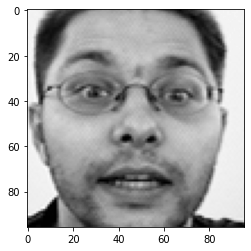

In [ ]:
plt.imshow(X_test[0].reshape(96,96),cmap = 'gray')
plt.show()

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred[0]

array([65.257225, 36.13281 , 27.524588, 36.964016, 59.330997, 36.96289 ,
       72.05108 , 37.86491 , 34.84623 , 37.05759 , 22.176664, 38.450047,
       57.559273, 26.537397, 79.54184 , 29.397303, 39.52047 , 25.7828  ,
       15.058166, 28.918509, 50.3177  , 51.63561 , 61.569534, 75.13347 ,
       33.377007, 75.27023 , 47.984516, 67.72817 , 48.00653 , 85.66994 ],
      dtype=float32)